In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [2]:
configurationFile = './configurations/02_outlet.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)

In [3]:
config['domain']

{'adjustParticle': False, 'adjustDomain': False, 'dim': 2, 'periodic': True}

In [4]:
nx = 256
L = 1
u_mag = 5
k = 1 * np.pi
TGV_override = False
targetRe = 1000

config['domain']['minExtent'] = [-2.2,-1.2]
config['domain']['maxExtent'] =  [2.2,1.2]
config['domain']['periodic'] = False

config['boundary']['active'] = True

config['particle'] = {'nx' : nx}
config['fluid'] = {'cs' : u_mag * 10}
config['compute'] = {'device': 'cuda'}
# config['compute'] = {'device': 'cpu'}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)
setViscosityParameters(config, targetRe, L, u_mag)

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$, $\alpha = {config["diffusion"]["alpha"]}$')


Re = 1000.0, $\nu_{sph} = 0.009999999776482582$, $\alpha = 0.035979680716991425$


In [5]:
config['particle']['support'] * 2

tensor(0.0712, device='cuda:0')

In [6]:
# from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

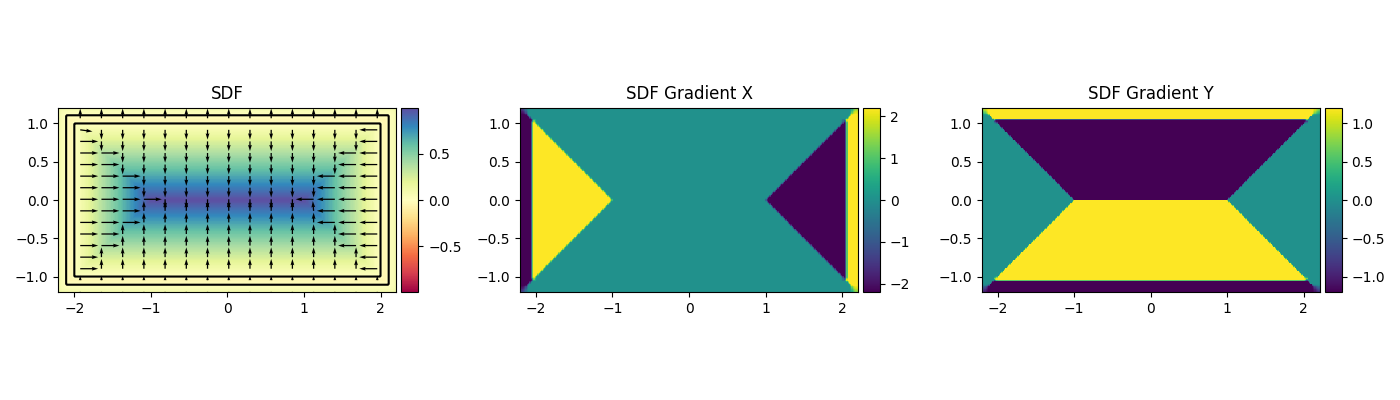

In [7]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('polygon')['function'](points, torch.tensor([[0.5,0.5],[0.5,-0.5],[-0.5,-0.5],[-0.5,0.5]]))
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/3,1/3]).to(points.device))
inner = lambda points: getSDF('box')['function'](points, torch.tensor([2,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([2 + config['particle']['support'] * 3,1 + config['particle']['support'] * 3]).to(points.device))


translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)

outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
sdf = operatorDict['invert'](sdf)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
sdf = sdf
plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

In [8]:
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import find_contour
# from diffSPH.v2.modules.divergence import computeDivergence

# def find_contour(f, minExtent, maxExtent, nGrid, level = 0):
#     contours = measure.find_contours(f.numpy(), level)
#     for ic in range(len(contours)):
#         contours[ic][:,0] = (contours[ic][:,0]) / (f.shape[0] - 1) * (maxExtent[0] - minExtent[0]).numpy() + minExtent[0].numpy()
#         contours[ic][:,1] = (contours[ic][:,1]) / (f.shape[0] - 1) * (maxExtent[1] - minExtent[1]).numpy() + minExtent[1].numpy()
#     return contours

In [9]:
ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1/2]).to(points.device))
inletSDF = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/4,1.5]).to(points.device))
outletRegion = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/4,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

inner = lambda points: getSDF('box')['function'](points, torch.tensor([2,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([2 + config['particle']['support'] * 2,1 + config['particle']['support'] * 2]).to(points.device))
outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
boundary_sdf = operatorDict['invert'](sdf)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/2,1/2]).to(points.device))
fluid_sdf = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/2, - 1/2]))


regions = [
    # {
    #     'sdf': inletSDF,
    #     'type': 'inlet',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    # {
    #     'sdf': inletSDF,
    #     'type': 'forcing',
    #     'forcingMode': 'immediate',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletSDF,
    #     'type': 'outlet',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletSDF])[0],
    #     'contour': find_contour(outletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletRegion,
    #     'type': 'mirror',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletRegion])[0],
    #     'contour': find_contour(outletRegion(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    {
        'sdf': boundary_sdf,
        'type': 'boundary',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [boundary_sdf])[0],
        'contour': find_contour(boundary_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },{
        'sdf': fluid_sdf,
        'type': 'fluid',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [fluid_sdf])[0],
        'contour': find_contour(fluid_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    }
    ]

# fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
# setPlotBaseAttributes(axis[0,0], config)
# # setPlotBaseAttributes(axis[0,1], config)

# # plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,0])


In [10]:


# # sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/2,1]).to(points.device))
# # outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# # fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

# print(outletSDF(torch.clone(points)).min())
# plotSDF(outletSDF(torch.clone(points),), X, Y, 2, 2)

In [11]:
from diffSPH.v2.plotting import setPlotBaseAttributes

# fig, axis = plt.subplots(1, 2, figsize = (14,5), squeeze = False)

# setPlotBaseAttributes(axis[0,0], config)
# setPlotBaseAttributes(axis[0,1], config)

# # def plotRegions(regions, axis):
# #     for region in regions:
# #         # visualizeParticles(region['particles'], axis[0,0], config)
# #         for ic, contour in enumerate(region['contour']):
# #             color = 'black'
# #             style = '-'
# #             if region['type'] == 'inlet':
# #                 color = 'green'
# #                 style = '--'
# #             if region['type'] == 'forcing':
# #                 color = 'blue'
# #                 style = ':'
# #             if region['type'] == 'outlet':
# #                 color = 'red'
# #                 style = ':'
# #             if region['type'] == 'mirror':
# #                 color = 'black'
# #                 style = ':'
# #             # axis[0,0].plot(contour[:,0], contour[:,1], color=color)
# #             axis.plot(contour[:,0], contour[:,1], color = color, ls = style, label = region['type'] if ic == 0 else None)
# #         if region['type'] == 'inlet':
# #             axis.scatter(region['particles']['positions'][:,0].detach().cpu().numpy(), region['particles']['positions'][:,1].detach().cpu().numpy(), color = 'green', s = 1)
#     # axis[0,0].legend()

# plotRegions(regions, axis[0,0])
# fig.tight_layout()

#     # axis[0,0].contour(X.numpy(), Y.numpy(), fx.numpy(), levels=[0], colors='black')

In [12]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict
from diffSPH.v2.plotting import computePSD, plotFFT, plotPSD, mapToGrid, visualizeParticleQuantity

# particleState, mask = sampleParticles(config, sdfs = [sdf])

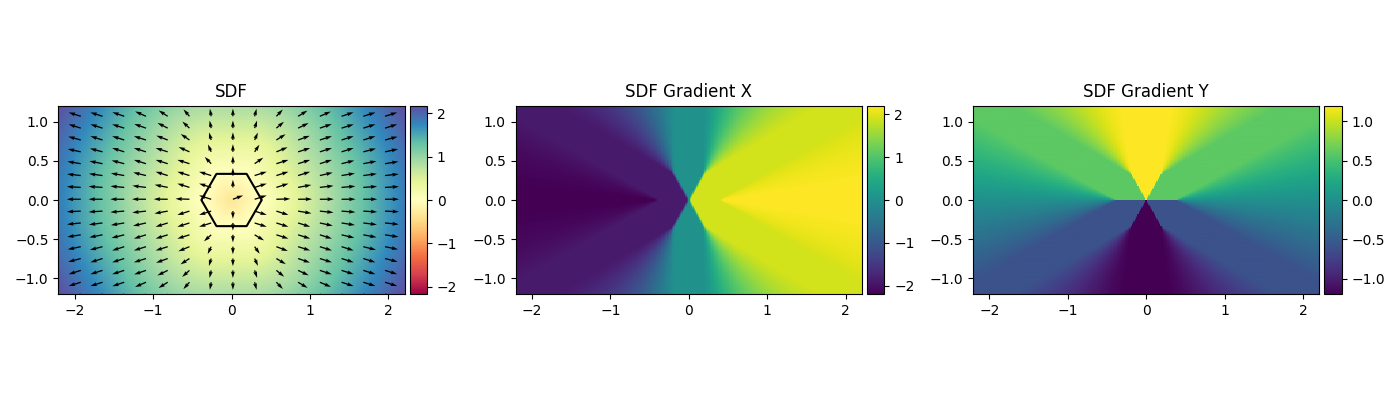

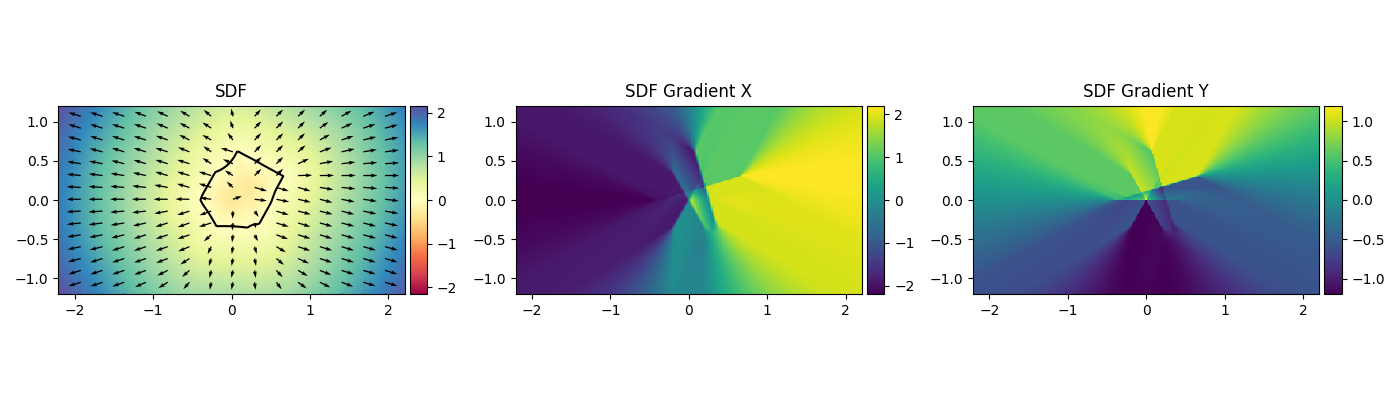

In [13]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 1/3)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/3,1/3]).to(points.device))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
fluid_sdf = sphere_a
plotSDF(fluid_sdf(torch.clone(points.to('cuda')),), X.to('cuda'), Y.to('cuda'), 2, 2)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([2,1/8]).to(points.device))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.0,-1/2 - 1/8]))
boundary_sdf = sdf
plotSDF(boundary_sdf(torch.clone(points),), X, Y, 2, 2)

In [14]:
print(config['gravity'])
config['gravity']['active'] = True
display(config['EOS'])
config['EOS']['type'] = 'stiffTait'

{'active': False, 'direction': [0, -1, 0], 'magnitude': 9.81, 'gravityMode': 'constant', 'potentialOrigin': [0, 0, 0]}


{'gasConstant': 8.14,
 'molarMass': 0.02897,
 'polytropicExponent': 7,
 'kappa': 1.3,
 'type': 'isoThermal'}

In [15]:
from diffSPH.v2.sampling import sampleParticles, processBoundarySDFs



# particleState, mask = sampleParticles(config, sdfs = [region['sdf'] for region in regions if region['type'] == 'inlet'])
particleState, mask = sampleParticles(config, sdfs = [region['sdf'] for region in regions if region['type'] == 'fluid'])

# sdf = 
boundaryState = processBoundarySDFs(particleState, config, [region['sdf'] for region in regions if region['type'] == 'boundary'], 'regular')

In [16]:
config['timestep']['dt'] = 1e-4
s = 2
perennialState = {
    'fluid': copy.deepcopy(particleState),
    'boundary': boundaryState,
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
    'uidCounter': particleState['numParticles']
}

u = 1
# perennialState['fluid']['velocities'][:,0] = u

In [17]:
perennialState['fluid']['positions'] += torch.normal(mean = 0, std = config['particle']['dx'] * 0.01, size = [perennialState['fluid']['numParticles'], 2], device = perennialState['fluid']['positions'].device)
perennialState['boundary']['positions'] += torch.normal(mean = 0, std = config['particle']['dx'] * 0.01, size = [perennialState['boundary']['numParticles'], 2], device = perennialState['boundary']['positions'].device)

In [18]:
config['simulation']

{'correctArea': False,
 'supportScheme': 'symmetric',
 'densityScheme': 'continuity',
 'timestamp': '2024_06_11-15_06_48'}

In [19]:
from diffSPH.v2.simulationSchemes.deltaPlus import callModule
from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

# from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.sphOps import sphOperationStates, LiuLiuConsistent
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationStates
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm, densityGradient
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.viscosity import computeViscosity
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.gravity import computeGravity
from diffSPH.v2.modules.sps import computeSPSTurbulence
from torch.profiler import record_function


from diffSPH.v2.modules.density import computeDensity
import torch
from diffSPH.v2.modules.neighborhood import neighborSearch, searchNeighbors
from diffSPH.v2.modules.normalizationMatrices import computeCovarianceMatrices
from diffSPH.v2.modules.inletOutlet import buildOutletGhostParticles
from diffSPH.v2.modules.mDBC import buildBoundaryGhostParticles, mDBCDensity


def simulationStep(state, config):
    with record_function("[SPH] - deltaSPH (1 - Neighbor Search)"):
        searchNeighbors(state, config)
        # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (2 - Ghost Particle Creation)"):
        state['boundaryGhost'] = buildBoundaryGhostParticles(state, config)
        state['outletGhost'] = buildOutletGhostParticles(regions, state, config)
        # torch.cuda.synchronize()
        
    with record_function("[SPH] - deltaSPH (3 - Density Computation)"):
        if config['simulation']['densityScheme'] == 'summation':
            if config['boundary']['active']:
                state['fluid']['densities'], state['boundary']['densities'] = callModule(state, computeDensity, config, 'all')
            else:
                state['fluid']['densities'], _ = callModule(state, computeDensity, config, 'fluid')
            torch.cuda.synchronize()
        if config['boundary']['active']:
            with record_function("[SPH] - deltaSPH (3 - mDBC Density Estimate)"):
                state['boundary']['densities'], state['boundaryGhost']['densities'] = mDBCDensity(state, config)
                # state['boundary']['densities'] += torch.abs(state['boundary']['distances']) / config['particle']['support'] * 2
                # torch.cuda.synchronize()

    if state['outletGhost'] is not None:
        with record_function("[SPH] - deltaSPH (4 - Outlet Processing)"):
            ghostState = state['outletGhost']
            neighbors = ghostState['neighborhood']['indices'][0]
            solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['densities'])

            cond = torch.logical_and(ghostState['numNeighbors'] >= 10, ghostState['sdf_dist'] < 2.5 * config['particle']['support'])
            cond = ghostState['numNeighbors'] >= 10

            def updateQuantity(state, ghostState, quantity, solution, cond):
                return torch.where(cond, solution[:,0] + torch.einsum('nd, nd -> n', ghostState['sdf_dist'][:,None] * ghostState['sdf_grad'] * 2, solution[:,1:]), quantity)
            state['fluid']['densities'][ghostState['fluidIndex']] = updateQuantity(state, ghostState, state['fluid']['densities'][ghostState['fluidIndex']], solution, cond)
            
            solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,0])
            state['fluid']['velocities'][ghostState['fluidIndex'],0] = updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,0], solution, cond)

            
            solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,1])
            state['fluid']['velocities'][ghostState['fluidIndex'],1] =updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,1], solution, cond)
            
            # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (5 - Normalization Matrices)"):
        # state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
        state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluid')
        state['fluid']['L'], state['fluid']['L.EVs'] = pinv2x2(state['fluid']['covarianceMatrix'])
        # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (6 - Density Gradient)"):
        state['fluid']['gradRho^L'],_ = callModule(state, renormalizedDensityGradient, config, 'fluid')
        # if config['boundary']['active']:
            # state['fluid']['gradRho^L'] += callModule(state, densityGradient, config, 'boundaryToFluid')[0]


        # state['boundary']['gradRho^L'] = callModule(state, densityGradient, config, 'boundary')[1]
        # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (7 - Diffusion and Momentum)"):
        state['fluid']['densityDiffusion'], _ = callModule(state, computeDensityDeltaTerm, config, 'fluid')
        # state['fluid']['densityDiffusion'] += callModule(state, computeDensityDeltaTerm, config, 'boundaryToFluid')[0]

        # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
        # torch.cuda.synchronize()
        if config['boundary']['active']:
            # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
            state['fluid']['velocityDiffusion'], state['boundary']['velocityDiffusion'] = callModule(state, computeViscosity, config, 'all')

            state['fluid']['momentumEquation'], state['boundary']['momentumEquation'] = callModule(state, computeMomentumEquation, config, 'all')
        else:
            state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')

            state['fluid']['momentumEquation'], _ = callModule(state, computeMomentumEquation, config, 'fluid')
        # torch.cuda.synchronize()
        state['fluid']['pressures'] = computeEOS(state['fluid'], config)

        if 'boundary' in state:
            state['boundary']['pressures'] = computeEOS(state['boundary'], config)

    with record_function("[SPH] - deltaSPH (8 - Pressure Forces)"):
        if 'boundary' in state:
            state['fluid']['pressureAccel'], state['boundary']['pressureAccel'] = callModule(state, computePressureAccel, config, 'all')
        else:
            state['fluid']['pressureAccel'], _ = callModule(state, computePressureAccel, config, 'fluid')
        # torch.cuda.synchronize()
    # state['fluid']['divergence'], state['boundary']['divergence'] = callModule(state, computePressureAccel, config, 'all')

    with record_function("[SPH] - deltaSPH (9 - External Forcing)"):
        state['fluid']['gravityAccel'] = computeGravity(state['fluid'], config)
        # torch.cuda.synchronize()

    # if config['SPS']['active']:
    #     with record_function("[SPH] - deltaSPH (7 - SPS Turbulence)"):
    #         state['fluid']['fluidSPSTurbulence'] = computeSPSTurbulence(simulationState, config)
    # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (10 - Integration)"):
        dudt = state['fluid']['pressureAccel'] + state['fluid']['gravityAccel'] + state['fluid']['velocityDiffusion']
        drhodt = state['fluid']['momentumEquation'] + state['fluid']['densityDiffusion']

        if state['outletGhost'] is not None:
            dudt[ghostState['fluidIndex'],:] = 0
            drhodt[ghostState['fluidIndex']] = 0

        if 'boundary' not in state:
            return (state['fluid']['velocities'].clone(), dudt, drhodt), (None, None, None)
        # torch.cuda.synchronize()   
        boundary_dudt = state['boundary']['pressureAccel'] #+ state['boundary']['velocityDiffusion']
        boundary_drhodt = state['boundary']['momentumEquation'] *0

        return (state['fluid']['velocities'].clone(), dudt, drhodt), (state['boundary']['velocities'].clone(), None, boundary_drhodt)
# from diffSPH.parameter import Parameter
# def getParameters():
#     return [
#         Parameter('deltaSPH', 'pressureSwitch', bool, False, required = False, export = True, hint = 'Switches the pressure force calculation to the Antuono Correction'),
#     ]


from torch.profiler import profile, record_function, ProfilerActivity


In [20]:
from diffSPH.v2.modules.inletOutlet import processInlet, processOutlet, processForcing
from diffSPH.v2.plotting import plotRegions

In [21]:
config['EOS']

{'gasConstant': 8.14,
 'molarMass': 0.02897,
 'polytropicExponent': 7,
 'kappa': 1.3,
 'type': 'stiffTait'}

In [22]:

from diffSPH.v2.finiteDifference import centralDifferenceStencil, continuousGradient
p = perennialState['boundary']['positions']
# inner()
sdf = inner
h = config['particle']['support']

stencil = centralDifferenceStencil(1, 2)
stencil = stencil.to(p.device)
sdfValues = sdf(p.cpu()).to(p.device)

sdfGradient = continuousGradient(sdf, p, stencil, 0.2 * h, 1)
perennialState['boundary']['normals'] = -sdfGradient / (torch.linalg.norm(sdfGradient, dim = 1, keepdim = True) + 1e-6)
perennialState['boundary']['distances'] = sdfValues

In [23]:
config['diffusion']['pi-switch']=False
config['shifting']

{'scheme': 'deltaSPH',
 'threshold': 0.05,
 'maxIterations': 1,
 'freeSurface': True,
 'R': 0.25,
 'n': 4,
 'CFL': 1.5,
 'computeMach': True,
 'solver': 'BiCGStab_wJacobi',
 'normalScheme': 'lambda',
 'projectionScheme': 'mat',
 'surfaceScaling': 0.1,
 'summationDensity': False,
 'useExtendedMask': False,
 'initialization': 'zero',
 'maxSolveIter': 64,
 'surfaceDetection': 'Barcasco',
 'active': True}

Text(0.5, 0.98, 'Time: 0.00 s, timestep: 0, dt: 1.00e-04 s, particles: 20633 (11449 fluid + 9184 boundary)')

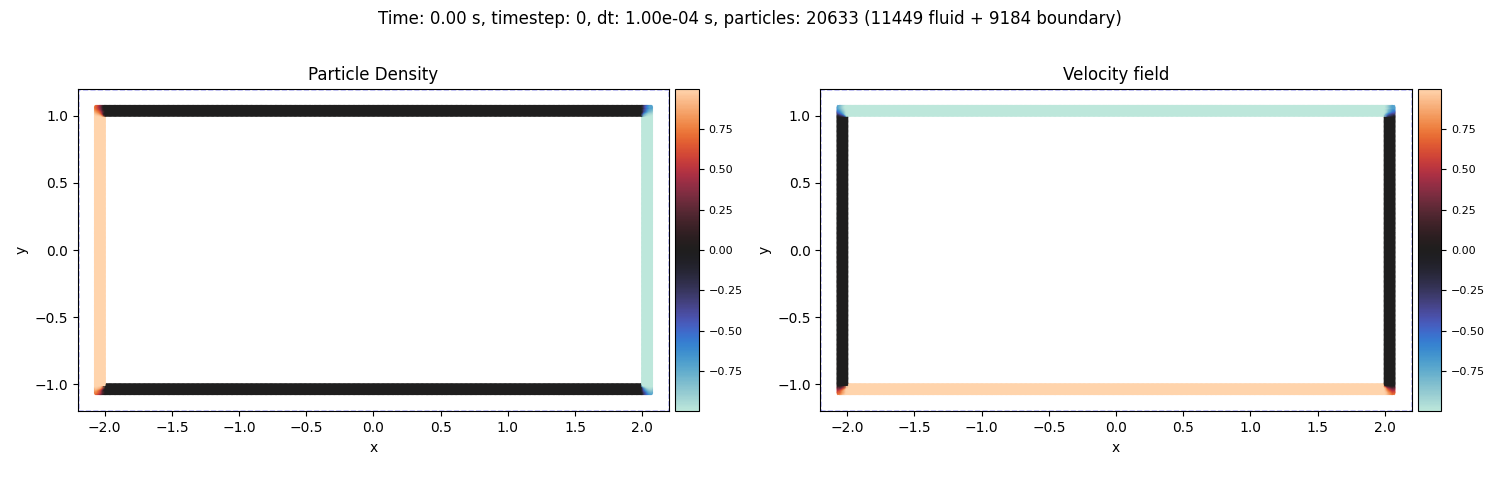

In [24]:
fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
s = 1

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = 'normals', mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'Particle Density', which = 'boundary', plotBoth = False, midPoint = 0)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 'normals', mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', streamLines = False, operation = None, title = 'Velocity field', plotBoth = False, which = 'boundary', midPoint = 0)


# axis[0,0].scatter(
#     perennialState['boundary']['positions'][:,0].detach().cpu().numpy(), 
#     perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), 
#     c = 'black',
#     marker = 'x',
#     s = 1,
#     alpha = 0.5)
# axis[0,1].scatter(
#     perennialState['boundary']['positions'][:,0].detach().cpu() .numpy(), 
#     perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), 
#     c = 'black',
#     marker = 'x',
#     s = 1,
#     alpha = 0.5)

fig.tight_layout()

fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')

In [25]:
# perennialState['boundary']

Text(0.5, 0.98, 'Time: 0.00 s, timestep: 0, dt: 1.00e-04 s, particles: 20633 (11449 fluid + 9184 boundary)')

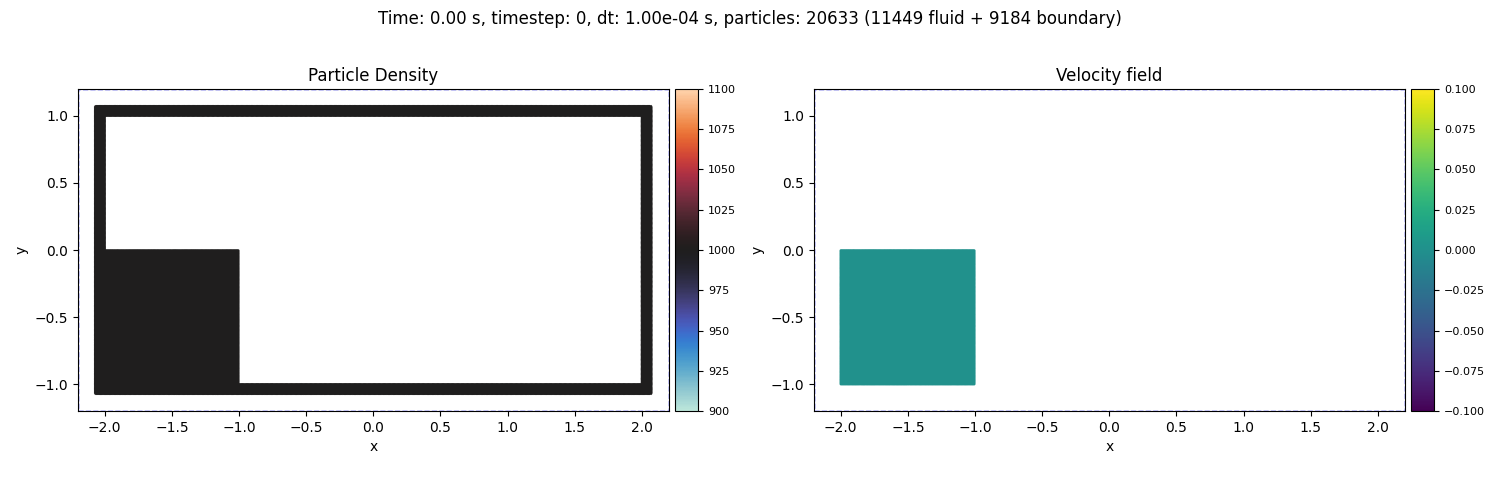

In [26]:
fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
s = 1

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = 'densities', mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'Particle Density', which = 'both', plotBoth = True, midPoint = config['fluid']['rho0'])
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 'velocities', mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Velocity field', plotBoth = False)


# axis[0,0].scatter(
#     perennialState['boundary']['positions'][:,0].detach().cpu().numpy(), 
#     perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), 
#     c = 'black',
#     marker = 'x',
#     s = 1,
#     alpha = 0.5)
# axis[0,1].scatter(
#     perennialState['boundary']['positions'][:,0].detach().cpu() .numpy(), 
#     perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), 
#     c = 'black',
#     marker = 'x',
#     s = 1,
#     alpha = 0.5)

fig.tight_layout()

fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')

In [27]:
from diffSPH.v2.modules.mDBC import mDBCDensity_cpp

In [28]:


# rho, shep = mDBCDensity(perennialState, config)

In [29]:

def buildBoundaryGhostParticles(perennialState, config):
    boundaryParticlePositions = perennialState['boundary']['positions'] 
    ghostParticlePositions = boundaryParticlePositions + 2 * perennialState['boundary']['distances'].view(-1,1) * perennialState['boundary']['normals'] 

    boundaryGhostState = {
        'positions': ghostParticlePositions,
        'areas': perennialState['boundary']['areas'],
        'masses': perennialState['boundary']['masses'],
        'densities': perennialState['boundary']['densities'],
        'supports': perennialState['boundary']['supports'],
        'velocities': perennialState['boundary']['velocities'],
        'numParticles': ghostParticlePositions.shape[0],
    }

    _, boundaryGhostState['neighborhood'] = neighborSearch(boundaryGhostState, perennialState['fluid'], config, True, perennialState['boundaryGhost']['neighborhood'] if 'boundaryGhost' in perennialState and 'neighborhood' in perennialState['boundaryGhost'] else None, perennialState['fluid']['datastructure'] if 'datastructure' in perennialState['fluid'] else None, False)
    _, boundaryGhostState['neighborhood'] = neighborSearch(boundaryGhostState, perennialState['fluid'], config, True, None, None, False)
    
    boundaryGhostState['numNeighbors'] = boundaryGhostState['neighborhood']['numNeighbors']
    # boundaryGhostState['neighborhood'] = neighborSearch(boundaryGhostState, perennialState['fluid'], config, computeKernels=True)
    # _, boundaryGhostState['numNeighbors'] = countUniqueEntries(boundaryGhostState['neighborhood']['indices'][0], ghostParticlePositions)

    return boundaryGhostState

perennialState['boundaryGhost'] = buildBoundaryGhostParticles(perennialState, config)

In [30]:
sdfValues

tensor([0.0906, 0.0842, 0.0785,  ..., 0.0786, 0.0844, 0.0907], device='cuda:0')

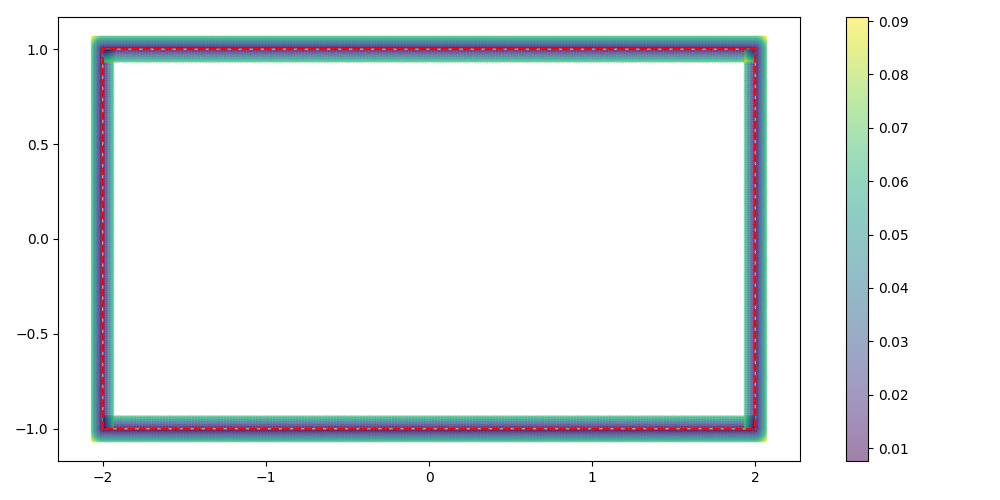

In [31]:
fig, axis = plt.subplots(1,1, figsize = (10,5), squeeze = False)
s = 1


from diffSPH.v2.finiteDifference import centralDifferenceStencil, continuousGradient
p = perennialState['boundary']['positions']
# inner()
sdf = inner
h = config['particle']['support']

stencil = centralDifferenceStencil(1, 2)
stencil = stencil.to(p.device)
sdfValues = sdf(p.cpu()).to(p.device)

sdfGradient = continuousGradient(sdf, p, stencil, 0.2 * h, 1)
perennialState['boundary']['normals'] = -sdfGradient / (torch.linalg.norm(sdfGradient, dim = 1, keepdim = True) + 1e-6)
perennialState['boundary']['distances'] = sdfValues

boundaryParticlePositions = perennialState['boundary']['positions']
ghostParticlePositions = boundaryParticlePositions + 2 * perennialState['boundary']['distances'].view(-1,1) * perennialState['boundary']['normals'] 

sc = axis[0,0].scatter(
    boundaryParticlePositions[:,0].detach().cpu().numpy(), 
    boundaryParticlePositions[:,1].detach().cpu().numpy(), 
    c = perennialState['boundary']['distances'].detach().cpu().numpy(),
    marker = 'o',
    s = 1,
    alpha = 0.5)
sc = axis[0,0].scatter(
    ghostParticlePositions[:,0].detach().cpu() .numpy(), 
    ghostParticlePositions[:,1].detach().cpu().numpy(), 
    c = perennialState['boundary']['distances'].detach().cpu().numpy(),
    marker = 'x',
    s = 1,
    alpha = 0.5)

fig.colorbar(sc, ax=axis[0,0])

axis[0,0].plot([-2,-2,2,2,-2], [-1,1,1,-1,-1], c = 'red', ls = '--')

fig.tight_layout()

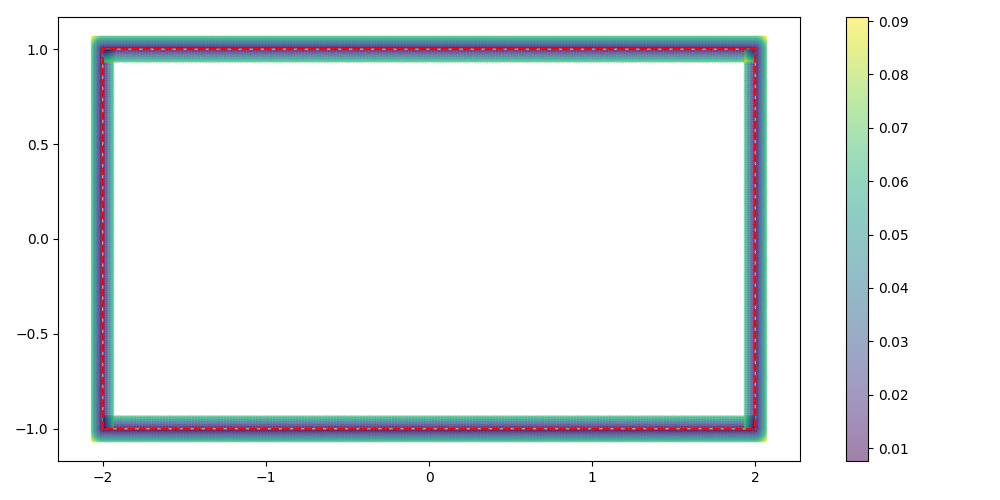

In [32]:
fig, axis = plt.subplots(1,1, figsize = (10,5), squeeze = False)
s = 1

boundaryParticlePositions = perennialState['boundary']['positions']
ghostParticlePositions = boundaryParticlePositions + 2 * perennialState['boundary']['distances'].view(-1,1) * perennialState['boundary']['normals'] 

sc = axis[0,0].scatter(
    boundaryParticlePositions[:,0].detach().cpu().numpy(), 
    boundaryParticlePositions[:,1].detach().cpu().numpy(), 
    c = perennialState['boundary']['distances'].detach().cpu().numpy(),
    marker = 'o',
    s = 1,
    alpha = 0.5)
sc = axis[0,0].scatter(
    ghostParticlePositions[:,0].detach().cpu() .numpy(), 
    ghostParticlePositions[:,1].detach().cpu().numpy(), 
    c = perennialState['boundary']['distances'].detach().cpu().numpy(),
    marker = 'x',
    s = 1,
    alpha = 0.5)

fig.colorbar(sc, ax=axis[0,0])

axis[0,0].plot([-2,-2,2,2,-2], [-1,1,1,-1,-1], c = 'red', ls = '--')

fig.tight_layout()

In [33]:

perennialState['boundaryGhost'] = buildBoundaryGhostParticles(perennialState, config)

masses = (perennialState['boundaryGhost']['masses'], perennialState['fluid']['masses']) 
densities = (perennialState['boundaryGhost']['densities'], perennialState['fluid']['positions'][:,1].flatten().clone())
densities = (perennialState['boundaryGhost']['densities'], perennialState['fluid']['densities'])

velocities = (perennialState['boundaryGhost']['velocities'], perennialState['fluid']['velocities'])

neighborhood = perennialState['boundaryGhost']['neighborhood']['indices']
kernels = perennialState['boundaryGhost']['neighborhood']['kernels']
kernelGradients = perennialState['boundaryGhost']['neighborhood']['gradients']
radialDistances = perennialState['boundaryGhost']['neighborhood']['distances']
directions = perennialState['boundaryGhost']['neighborhood']['vectors']
supports = perennialState['boundaryGhost']['neighborhood']['supports']

numParticles = (perennialState['boundaryGhost']['numParticles'], perennialState['fluid']['numParticles'])
numNeighbors = perennialState['boundaryGhost']['numNeighbors']

boundaryPositions = (perennialState['boundary']['positions'], perennialState['boundaryGhost']['positions'])

neighborOffsets = perennialState['boundaryGhost']['neighborhood']['neighborOffsets']


q = perennialState['fluid']['positions'][:,1].flatten().clone()
q = perennialState['fluid']['densities']

boundaryGhostState = perennialState['boundaryGhost']

shepardNominator = sphOperationStates(boundaryGhostState, perennialState['fluid'], (perennialState['boundaryGhost']['densities'], q), operation = 'interpolate', neighborhood = boundaryGhostState['neighborhood'])
shepardDenominator = sphOperationStates(boundaryGhostState, perennialState['fluid'], 
        (torch.ones_like(boundaryGhostState['masses']), torch.ones_like(perennialState['fluid']['masses'])),
        # (boundaryGhostState['densities'] / boundaryGhostState['masses'], perennialState['fluid']['densities'] / perennialState['fluid']['masses']),
            operation = 'interpolate', neighborhood = boundaryGhostState['neighborhood'])

shepardDensity = shepardNominator / (shepardDenominator + 1e-7)

gradientSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], (boundaryGhostState['densities'], q), operation = 'gradient', neighborhood = boundaryGhostState['neighborhood'], gradientMode = 'naive')

b = torch.hstack((shepardNominator[:,None], gradientSum))

volumeSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], (torch.ones_like(boundaryGhostState['masses']), torch.ones_like(perennialState['fluid']['masses'])), operation = 'interpolate', neighborhood = boundaryGhostState['neighborhood'])
volumeGradSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], (torch.ones_like(boundaryGhostState['masses']), torch.ones_like(perennialState['fluid']['masses'])), operation = 'gradient', neighborhood = boundaryGhostState['neighborhood'], gradientMode = 'naive')

xij = -boundaryGhostState['neighborhood']['vectors'] * boundaryGhostState['neighborhood']['distances'].view(-1,1) * config['particle']['support']

positionSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], xij, operation = 'interpolate', neighborhood = boundaryGhostState['neighborhood'])
positionMatrix = sphOperationStates(boundaryGhostState, perennialState['fluid'], xij, operation = 'gradient', neighborhood = boundaryGhostState['neighborhood'], gradientMode = 'naive')

A_g = torch.zeros((boundaryGhostState['numParticles'], 3, 3), dtype = xij.dtype, device = xij.device)

A_g[:,0,0] = volumeSum
A_g[:,1,0] = volumeGradSum[:,0]
A_g[:,2,0] = volumeGradSum[:,1]

A_g[:,0,1] = positionSum[:,0]
A_g[:,0,2] = positionSum[:,1]

A_g[:,1,1] = positionMatrix[:,0,0]
A_g[:,1,2] = positionMatrix[:,0,1]
A_g[:,2,1] = positionMatrix[:,1,0]
A_g[:,2,2] = positionMatrix[:,1,1]


neighCounts = boundaryGhostState['numNeighbors']
A_g_inv = torch.zeros_like(A_g)
A_g_inv[neighCounts > 4] = torch.linalg.pinv(A_g[neighCounts > 4])

res = torch.matmul(A_g_inv, b.unsqueeze(2))[:,:,0]
numPtcls = boundaryGhostState['numParticles']
restDensity = config['fluid']['rho0']

interpolated = torch.zeros(numPtcls, dtype = xij.dtype, device = xij.device) * 0
# boundaryDensity[neighCounts > 0] = shepardDensity[neighCounts > 0] #/ restDensity
threshold = 5
boundaryParticlePositions = perennialState['boundary']['positions']
ghostParticlePositions = boundaryGhostState['positions']
relPos = boundaryParticlePositions - ghostParticlePositions
# relDist = torch.linalg.norm(relPos, dim = 1)
# relDist = torch.clamp(relDist, min = 1e-7, max = config['particle']['support']*3.)
# relPos = relPos * (relDist / (torch.linalg.norm(relPos, dim = 1) + 1e-7))[:,None]

interpolated[neighCounts > threshold] = (res[neighCounts > threshold,0] + torch.einsum('nu, nu -> n',(relPos)[neighCounts > threshold, :], res[neighCounts > threshold, 1:] ))
# interpolated = (res[:,0] + 1*torch.einsum('nu, nu -> n',(relPos), res[:, 1:] ))

# boundaryDensity = torch.clamp(boundaryDensity, min = restDensity)
# self.fluidVolume = self.boundaryVolume / self.boundaryDensity

solution, M, b = LiuLiuConsistent(boundaryGhostState, perennialState['fluid'], perennialState['fluid']['positions'][:,1].flatten().clone())
# boundaryDensity = 


# boundaryDensity = torch.ones(numPtcls, dtype = xij.dtype, device = xij.device) * restDensity
# boundaryDensity[neighCounts > 0] = shepardDensity[neighCounts > 0] #/ restDensity
# threshold = 5

interpolated = torch.clamp(interpolated, min = 1000)
# interpolated += torch.abs(perennialState['boundary']['distances']) / config['particle']['support'] * 2


relPos = boundaryParticlePositions - ghostParticlePositions

# interpolated[neighCounts > threshold] = res[neighCounts > threshold,0]
# extrapolated = solution[:,0] + torch.einsum('nd, nd -> n', -relPos, solution[:,1:])

# # neighCounts = boundaryGhostState['numNeighbors']
# # boundaryDensity = shepardDensity
# boundaryDensity[neighCounts > threshold] = torch.clamp(extrapolated[neighCounts > threshold], min = restDensity)
# interpolated = torch.clamp(interpolated, min = restDensity)

# print(f'Boundary Density for Timestep {perennialState["timestep"]}: {boundaryDensity.min().item()} - {boundaryDensity.max().item()} mean: {boundaryDensity.mean().item()}')
# print(f'shepardDensity: {shepardDensity.min().item()} - {shepardDensity.max().item()} mean: {shepardDensity.mean().item()}')
# print(f'Shephard Nom: {shepardNominator.min().item()} - {shepardNominator.max().item()} mean: {shepardNominator.mean().item()}')
# print(f'Shephard Denom: {shepardDenominator.min().item()} - {shepardDenominator.max().item()} mean: {shepardDenominator.mean().item()}')
# print(f'neighCounts: {neighCounts.min().item()} - {neighCounts.max().item()} mean: {neighCounts.median().item()}')

# return boundaryDensity, shepardDensity

# rho, shep = mDBCDensity_cpp(
#     masses, densities, boundaryPositions,

#     numParticles[0], numParticles[1],
#     neighborhood,
#     numNeighbors, neighborOffsets,
#     kernels, kernelGradients,
#     radialDistances, directions, supports,
#     -1000
# )


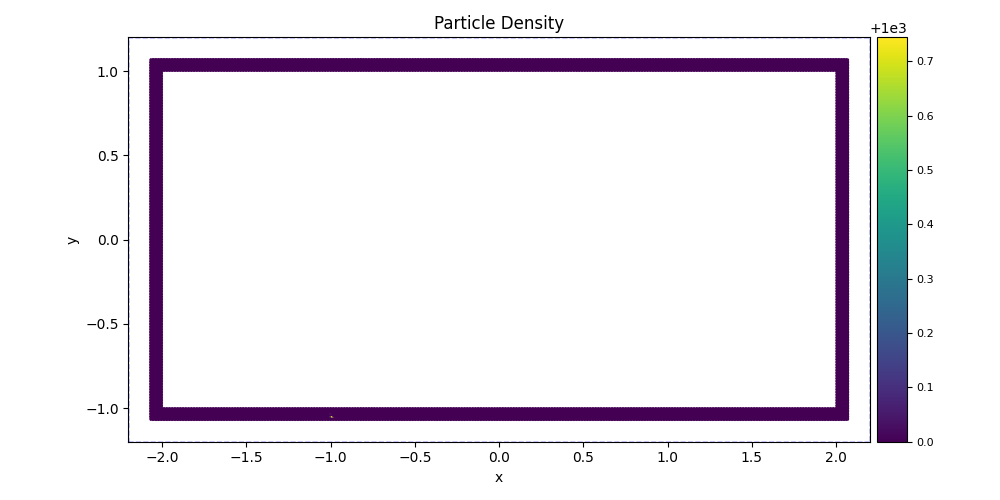

In [34]:
fig, axis = plt.subplots(1,1, figsize = (10,5), squeeze = False)
s = 1

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = (perennialState['fluid']['densities'], torch.clamp(interpolated, min = 1000)), mapping = '.x', s = s, scaling = 'lin', gridVisualization=False, cmap = 'viridis', title = 'Particle Density', which = 'boundary', plotBoth = False, midPoint = 1000)

# indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = (perennialState['fluid']['positions'][:,1], numNeighbors), mapping = '.x', s = s,  scaling = 'lin', gridVisualization=False, cmap = 'viridis', title = 'Particle Density', which = 'boundary', plotBoth = False, midPoint = 1000)
fig.tight_layout()

In [35]:
perennialState['boundary']['densities'] - interpolated

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

Text(0.5, 0.98, 'Time: 0.00 s, timestep: 0, dt: 1.00e-04 s, particles: 20633 (11449 fluid + 9184 boundary)')

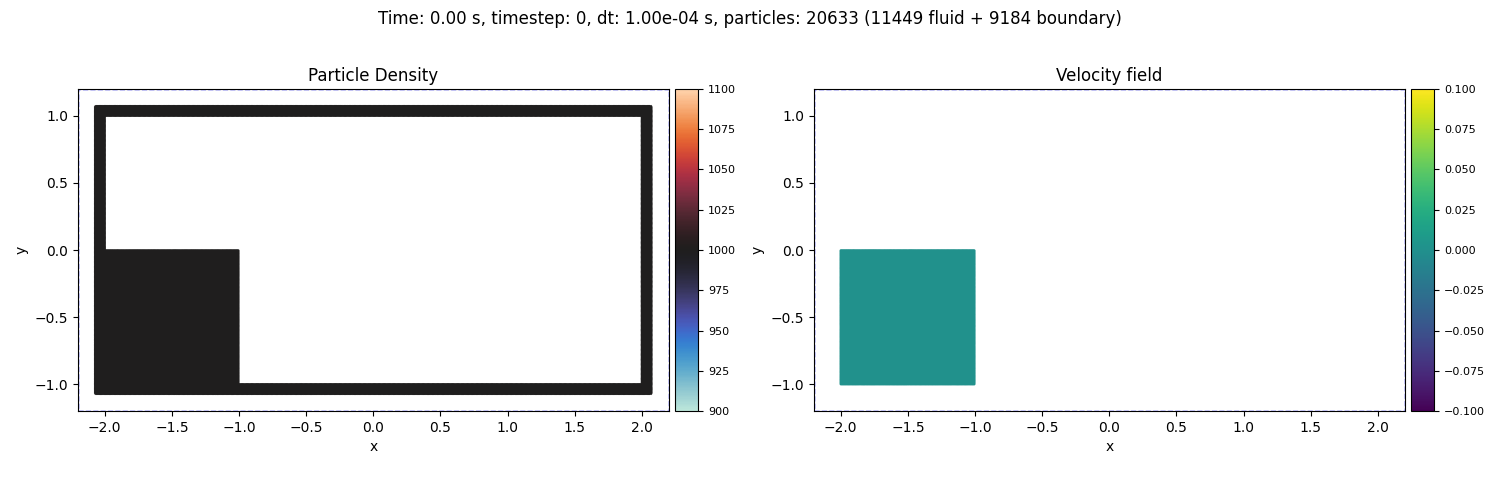

In [36]:
fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
s = 1

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = 'densities', mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'Particle Density', which = 'both', plotBoth = True, midPoint = 1000)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 'velocities', mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Velocity field', plotBoth = False, which = 'fluid', midPoint = 1000)


# axis[0,0].scatter(
#     perennialState['boundary']['positions'][:,0].detach().cpu().numpy(), 
#     perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), 
#     c = 'black',
#     marker = 'x',
#     s = 1,
#     alpha = 0.5)
# axis[0,1].scatter(
#     perennialState['boundary']['positions'][:,0].detach().cpu() .numpy(), 
#     perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), 
#     c = 'black',
#     marker = 'x',
#     s = 1,
#     alpha = 0.5)

fig.tight_layout()

fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')

In [37]:

perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= None)

In [38]:
perennialState['boundary']

{'positions': tensor([[-2.0641, -1.0641],
         [-2.0548, -1.0640],
         [-2.0455, -1.0639],
         ...,
         [ 2.0456,  1.0640],
         [ 2.0549,  1.0641],
         [ 2.0642,  1.0641]], device='cuda:0'),
 'areas': tensor([8.7891e-05, 8.7891e-05, 8.7891e-05,  ..., 8.7891e-05, 8.7891e-05,
         8.7891e-05], device='cuda:0'),
 'pressures': tensor([0.0000e+00, 2.3842e+00, 0.0000e+00,  ..., 1.1189e+04, 1.2036e+04,
         1.2943e+04], device='cuda:0'),
 'masses': tensor([0.0879, 0.0879, 0.0879,  ..., 0.0879, 0.0879, 0.0879], device='cuda:0'),
 'supports': tensor([0.0356, 0.0356, 0.0356,  ..., 0.0356, 0.0356, 0.0356], device='cuda:0'),
 'index': tensor([   0,    1,    2,  ..., 9181, 9182, 9183], device='cuda:0'),
 'densities': tensor([1000.0000, 1000.0009, 1000.0000,  ..., 1004.4166, 1004.7464,
         1005.0985], device='cuda:0'),
 'velocities': tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]]

In [39]:
priorState['boundary']

{'positions': tensor([[-2.0641, -1.0641],
         [-2.0548, -1.0640],
         [-2.0455, -1.0639],
         ...,
         [ 2.0456,  1.0640],
         [ 2.0549,  1.0641],
         [ 2.0642,  1.0641]], device='cuda:0'),
 'areas': tensor([8.7891e-05, 8.7891e-05, 8.7891e-05,  ..., 8.7891e-05, 8.7891e-05,
         8.7891e-05], device='cuda:0'),
 'pressures': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'masses': tensor([0.0879, 0.0879, 0.0879,  ..., 0.0879, 0.0879, 0.0879], device='cuda:0'),
 'supports': tensor([0.0356, 0.0356, 0.0356,  ..., 0.0356, 0.0356, 0.0356], device='cuda:0'),
 'index': tensor([   0,    1,    2,  ..., 9181, 9182, 9183], device='cuda:0'),
 'densities': tensor([1000.0000, 1000.0009, 1000.0000,  ..., 1004.4166, 1004.7464,
         1005.0985], device='cuda:0'),
 'velocities': tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]], device='cuda:0'),
 'accelerations': tensor([[0., 0.],
 

In [40]:
from diffSPH.v2.plotting import exportPlot, postProcessPlot
priorState = None
for i in tqdm(range(30000)):
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    perennialState['fluid']['shiftAmount'] = dx
    perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]
    # perennialState = simulationStep(perennialState, config)
    # perennialState['fluidGhostParticles'] = buildOutletGhostParticles(regions, perennialState, config)


    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')
    # perennialState['fluid']['positions'] += perennialState['fluid']['velocities'] * config['timestep']['dt']

    if i % 100 == 0:
        # printState(perennialState)
        # print(f'Iteration {i}')
        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(indexPlot, visualizationState, 'densities')
        updatePlot(quantPlot, visualizationState, 'velocities')
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)

    for emitter in regions:
        if emitter['type'] == 'inlet':
            processInlet(perennialState, emitter)
        if emitter['type'] == 'outlet':
            processOutlet(emitter, config, perennialState)
        if emitter['type'] == 'forcing':
            processForcing(emitter, config, perennialState)


  0%|          | 0/30000 [00:00<?, ?it/s]

In [41]:
config['shifting']['active'] = False

In [41]:

import subprocess
import shlex

outFile = config['plot']['namingScheme'] if config['plot']['namingScheme'] != 'timestep' else config["simulation"]["timestamp"]
if config['plot']['namingScheme'] == 'timestep':
    outFolder = f'{config["plot"]["exportPath"]}/{config["simulation"]["timestamp"]}/'
else:
    outFolder = f'{config["plot"]["exportPath"]}/{config["plot"]["namingScheme"]}/'

os.makedirs(outFolder, exist_ok = True)
# print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos[x];[x][1:v]paletteuse" {outFile}.gif'

subprocess.run(shlex.split(command))
subprocess.run(shlex.split(commandB))
subprocess.run(shlex.split(commandC))

[Parsed_palettegen_2 @ 0x653b336a4c00] Dupped color: FF575757
[Parsed_palettegen_2 @ 0x653b336a4c00] Dupped color: FF9C9C9C
[Parsed_palettegen_2 @ 0x653b336a4c00] Dupped color: FFD34935
[Parsed_palettegen_2 @ 0x653b336a4c00] Dupped color: FFFCFCFC


CompletedProcess(args=['ffmpeg', '-loglevel', 'warning', '-hide_banner', '-y', '-i', 'output/2024_06_11-14_43_23/output.mp4', '-i', 'output/palette.png', '-filter_complex', 'fps=30,scale=640:-1:flags=lanczos[x];[x][1:v]paletteuse', '2024_06_11-14_43_23.gif'], returncode=0)